Alexander Hyde<br>
Phys 434 AB<br>
Partner: Max Wang <br>
# Lab 4

In [93]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
plt.rcParams["figure.figsize"] = (22,8)

hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

# Problem 1

In this problem we have a data set of around 25 million rows worth of cosmic rays counted over 100 ms, the Solar phase, the Earth's longitude, and the time associated with each measurement. Here I'll plot different segments of this data set in pairs of the segment's cosmic ray counts plotted as a 2D histogram, and the segment's Solar phase and Earth's longitude, both plots using time as the x-axis.

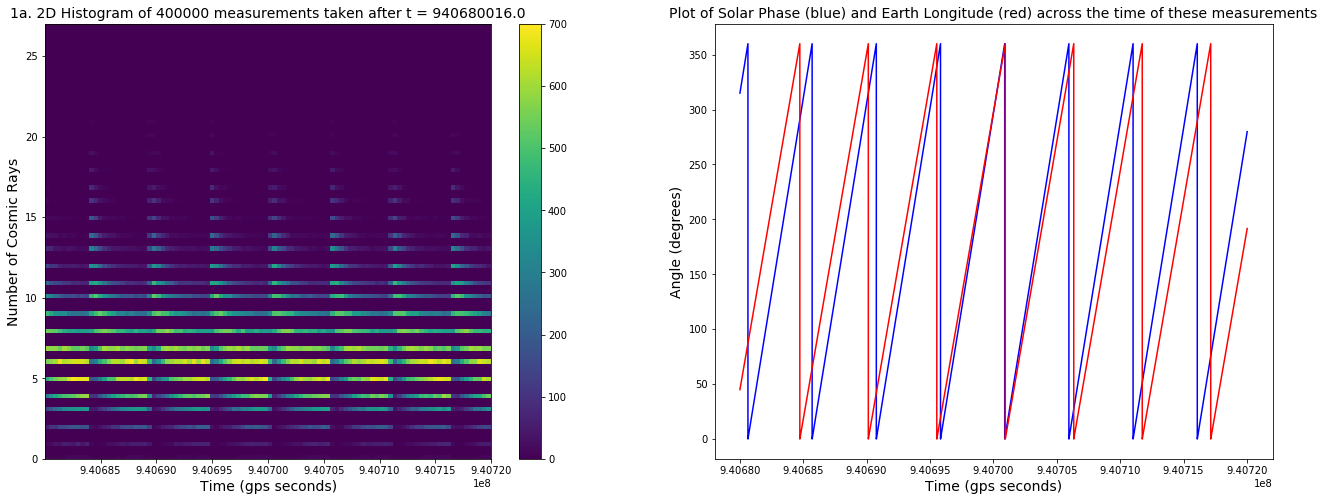

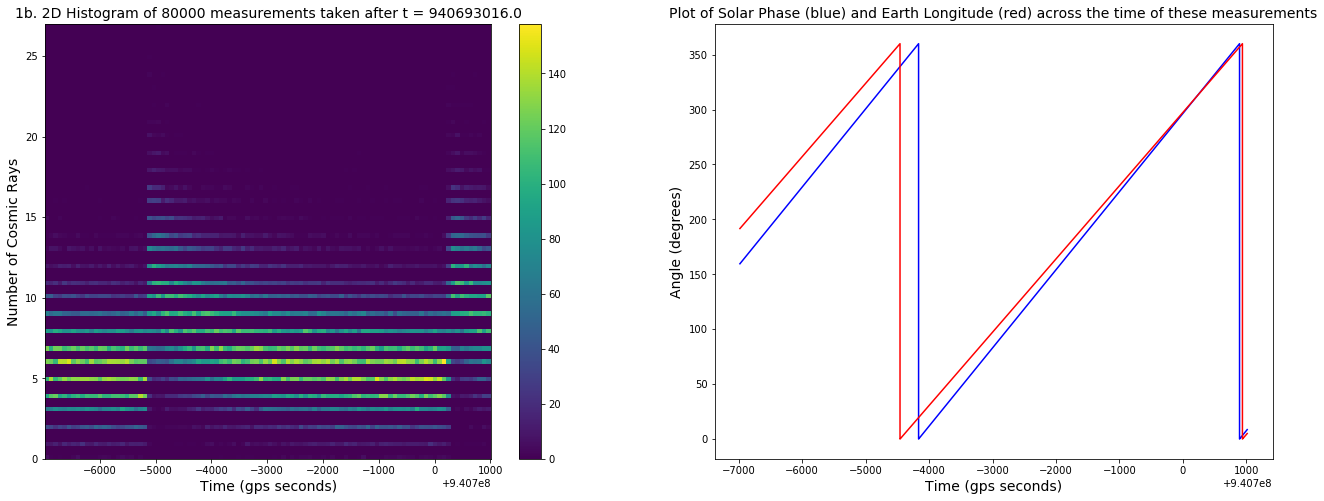

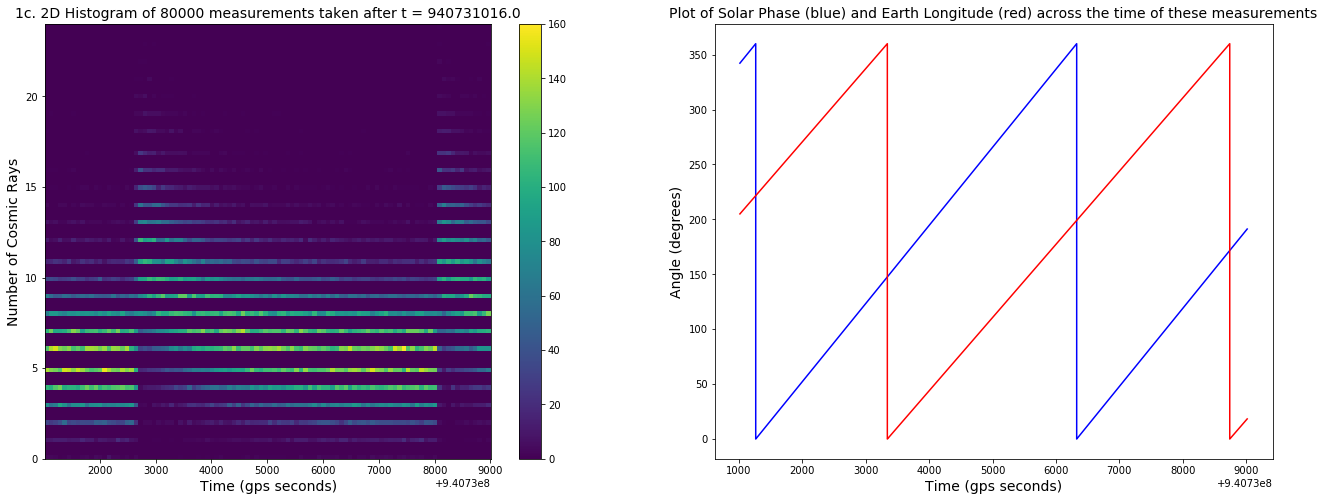

In [8]:
def trimXPoints(X,x0,label):
    t = data[0,:(x0+X)][x0:]
    sp = data[1,:(x0+X)][x0:]
    el = data[2,:(x0+X)][x0:]
    pc = data[3,:(x0+X)][x0:]
    
    fig,ax = plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.hist2d(t,pc,100)
    plt.colorbar()
    plt.title("1" + label + ". 2D Histogram of " + str(X) + " measurements taken after t = " + str(t[0]),fontsize = 14)
    plt.xlabel("Time (gps seconds)",fontsize = 14)
    plt.ylabel("Number of Cosmic Rays",fontsize = 14)
    plt.subplot(1,2,2)
    plt.plot(t,sp,color="Blue")
    plt.plot(t,el,color="Red")
    plt.title("Plot of Solar Phase (blue) and Earth Longitude (red) across the time of these measurements",fontsize = 14)
    plt.xlabel("Time (gps seconds)",fontsize = 14)
    plt.ylabel("Angle (degrees)",fontsize = 14)
    plt.show()

trimXPoints(400000,0,"a")
trimXPoints(80000,130000,"b")
trimXPoints(80000,510000,"c")

Ideally, a repeated measurement of cosmic rays accumulated over 100 ms should result in a distribution that stays constant throughout time, but as you can see in figure **1a**'s 2D histogram, there's a periodic pattern of signal contamination where the Vela satellite picks up extra cosmic rays on average for a short burst of time before it gradually shifts back down to reading a more regular, lesser number cosmic rays on average. While you could reason that the inverse could be true too, that the Vela satellite regularly picks up more cosmic rays on average and that the signal contamination is the cosmic rays being blocked; I'd argue against this, since if you were to draw a curved line approximately through the center of the distribution through one of these cycles, you'd find that the line curves concavely upwards, which shows that the distribution sharply declines from its higher side, and relaxes slowly down to its lower side. I think it's more reasonable to assume that a signal's being repeatedly caught before it slowly decays, than to assume that the standard cosmic ray distribution gets slowly blocked, before rapidly being unblocked.<br>

The cyclic nature of figure **1a**'s histogram seems connected to the Solar phase and Earth's longitude plots, since the periods of each of their cycles seem visibly close. It's worth noting that the Solar phase has a slightly shorter period than the Earth longitude (as can be visually seen in **1a**), resulting in a Moire-like pattern where sometimes the Solar phase and Earth longitude have nearly the same angle (like **1b**), or other times where they clearly don't (like **1c**). This also tells me that it's not quite safe to assume that the cosmic ray readings have the same period as either of these readings, I'll have to determine its period later.<br>

The **1a** plots shows multiple cycles while the **1b** and **1c** plots zoom in on one cycle each. When reading the 2D histograms, notice that the cosmic ray readings are discrete integers, our background pdf is going to need to be discrete as well to accomodate this. Since cosmic rays are rare enough that we're asking in this case, how many do we get in a 100 ms time interval, I'll start by assuming that the background cosmic ray count can be represented by a Poisson pdf. Now I'll take a thin slice out of **1c** over two 200 second intervals and plot them as 1D histograms:<br>

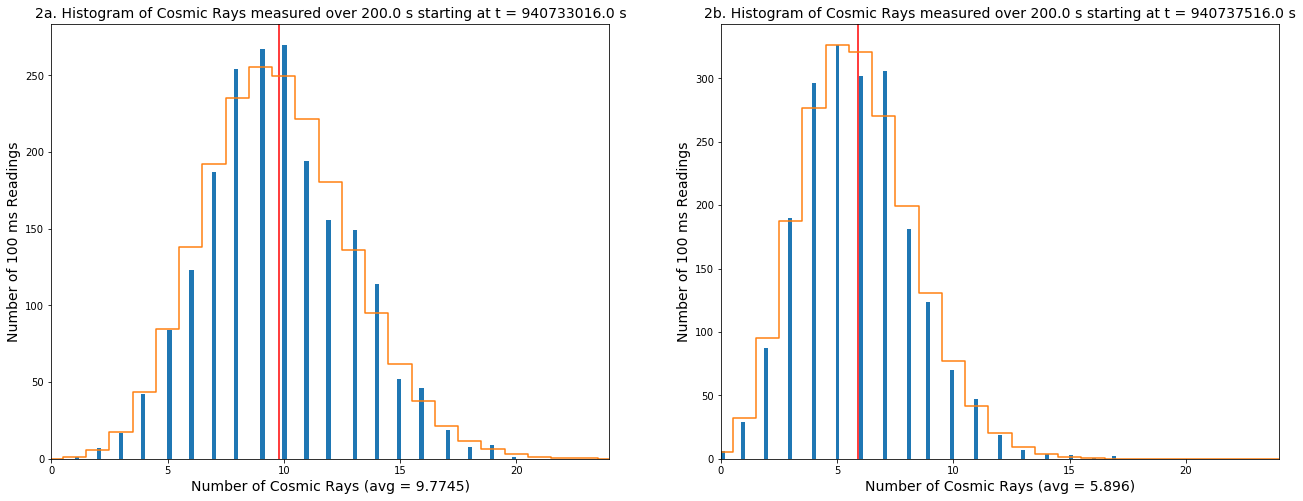

In [32]:
def slicePC(X,x0,label):
    pc = data[3,:(x0+X)][x0:]
    avg = sum(pc)/len(pc)
    plt.xlim(0,24)
    plt.hist(pc,100)
    plt.axvline(x=avg,color="Red")
    plt.title("2" + label + ". Histogram of Cosmic Rays measured over " + str(0.1*X) + " s starting at t = " + str(data[0,x0]) + " s",fontsize=14)
    plt.xlabel("Number of Cosmic Rays (avg = " + str(avg) + ")",fontsize=14)
    plt.ylabel("Number of 100 ms Readings",fontsize=14)
    x = np.linspace(0,24,25)
    f = stats.poisson.pmf(x,avg)*X
    plt.step(x,f,where="mid")

fig,ax = plt.subplots(1,2)
plt.subplot(1,2,1)
slicePC(2000,530000,"a")
plt.subplot(1,2,2)
slicePC(2000,575000,"b")
plt.show()

When looking at these histograms, take note of where they were taken from **1c**. **2a** was taken from +3016.0 to +3216.0 s, and **2b** was taken from +7516.0 to +7716.0 s. You can quite visibly tell that the average (the red line) number of cosmic rays in these 200 s intervals went down as you go from **2a** to **2b**. You can also easily see this effect by looking at **1c**, and noticing how the vertical distribution shifts downwards to a smaller average number of cosmic rays as you go from +3016.0 s to +7516.0 s.<br>

That aside, I fit a Poisson pdf over both **2a** and **2b** using their averages, and visually speaking, the fits seem to envelop the data nicely. But since the average number of cosmic rays changes over time, I would suggest that the background pdf also changes over time accordingly. Next I'll try to plot this average as a function of time:

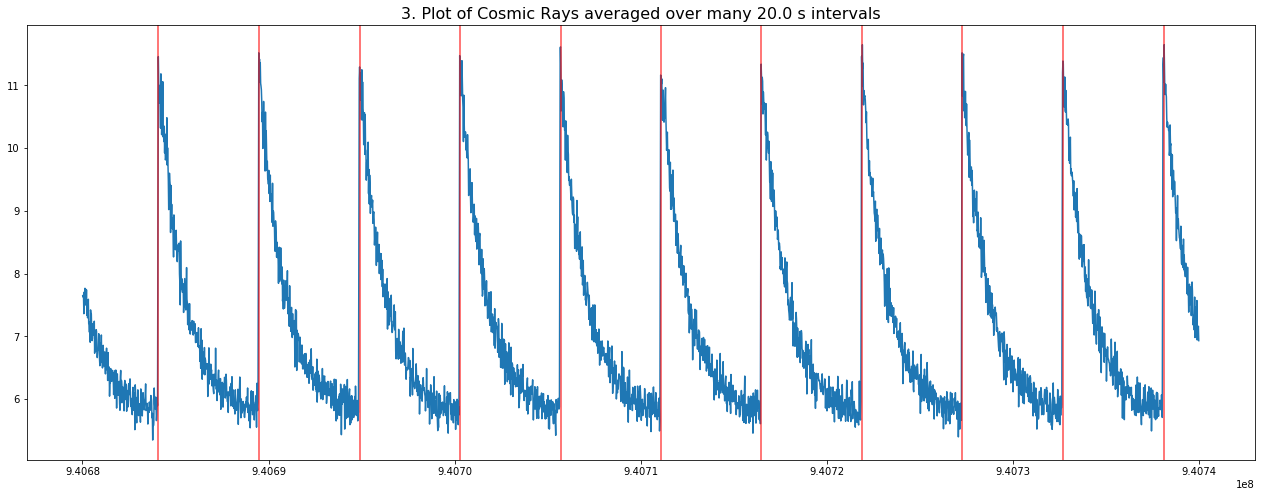

In [72]:
def avgGraph(W,w):
    t = []
    pcA = []
    for i in range(0,W,w):
        t.append(data[0,i])
        pc = data[3,:(i+w)][i:]
        pcA.append(sum(pc)/len(pc))
    iPeaks = []
    tPeaks = []
    for i in range(0,len(t),10):
        lowP = pcA[i]
        highP = pcA[i+9]
        if highP > 3+lowP:
            peakP = max(pcA[:(i+9)][i:])
            pIndex = pcA.index(peakP,i,i+9)
            iPeaks.append(pIndex)
            tPeaks.append(t[pIndex])
    return t,pcA,iPeaks,tPeaks

t,pcA,iPeaks,tPeaks = avgGraph(600000,200)
fig,ax = plt.subplots(1,1)
plt.plot(t,pcA)
for i in tPeaks:
    plt.axvline(x=i,color="Red",alpha=0.7)
plt.title("3. Plot of Cosmic Rays averaged over many " + str(0.1*w) + " s intervals",fontsize=16)
plt.show()

I also ended up making a list of the times that this graph peaked, and plotted those as red lines. From here on out, I'll analyze the range of the data set starting from the first peak and ending at the 25 millionth point.<br>

Now what I want out of this graph is a model of the average of the cosmic ray count as a function of time. Here I'll first measure the average elapsed time between each peak, then I'll fold and average the data in these periods into one period to get a model, and finally I'll make a function which returns the model's average when you input any time into it by interpolating between two points on the model:

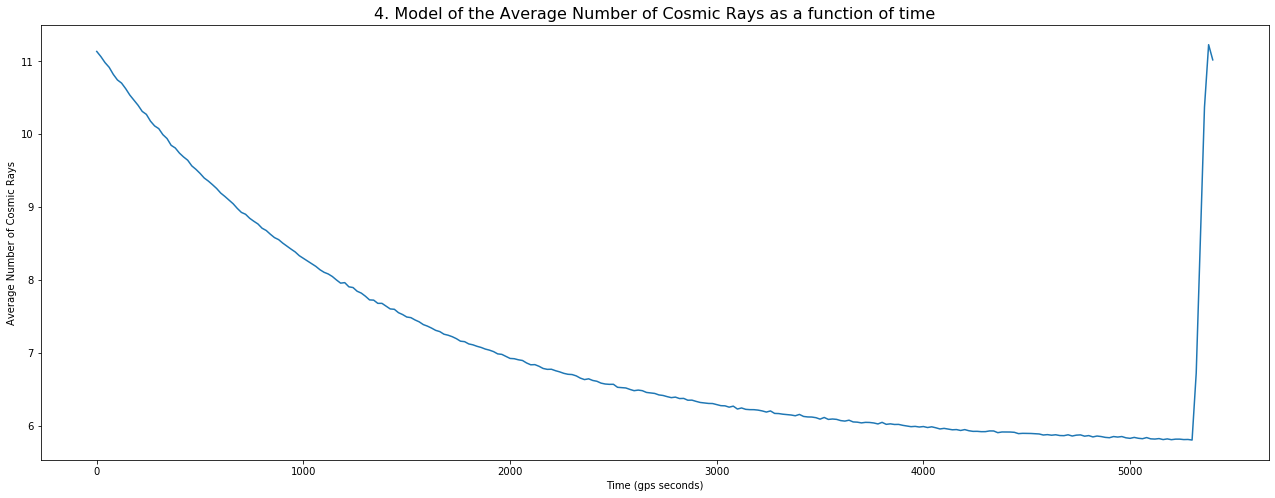

Average of Figure 2a based on model =  9.943892176937535
Average of Figure 2b based on model =  5.858261549465654


In [76]:
t,pcA,iPeaks,tPeaks = avgGraph(25000000,200)

periods = np.diff(tPeaks)
avgT = sum(periods)/len(periods)

t_o = np.subtract(t,tPeaks[0]) # t offset
t_f = [] # t folded
pcA_f = [] # pcA folded
for i in range(iPeaks[0],iPeaks[len(iPeaks)-1]):
    t_f.append(t_o[i]%avgT)
    pcA_f.append(pcA[i])

def avgBetween(low,high):
    pcA_b = [] #pcA between two times
    for i in range(0,len(t_f)):
        if low <= t_f[i] and t_f[i] <= high:
            pcA_b.append(pcA_f[i])
    return sum(pcA_b)/len(pcA_b)

w_t = 0.1*w
rangeT = avgT - avgT%w_t # looping range
t_m = np.linspace(0,rangeT,np.int(rangeT/w_t+1)) # t model
pcA_m = [] # pcA model
for i in range(0,len(t_m)-1):
    pcA_m.append(avgBetween(t_m[i],t_m[i+1]))
if avgT%w_t > 0:
    pcA_m.append(avgBetween(rangeT,avgT))

def modelPCAvg(t_i):
    t_if = (t_i - tPeaks[0])%avgT # t input folded
    i_0 = np.int((t_if - t_if%w_t)/w_t) # left t_m point
    i_1 = i_0 + 1 # right t_m point
    pcA_out = ((pcA_m[i_1]-pcA_m[i_0])/(t_m[i_1]-t_m[i_0]))*(t_if-t_m[i_0]) + pcA_m[i_0] # interpolation between the two surrounding points of the input time
    return pcA_out

fig,ax = plt.subplots(1,1)
plt.plot(t_m,pcA_m)
plt.title("4. Model of the Average Number of Cosmic Rays as a function of time",fontsize=16)
plt.xlabel("Time (gps seconds)")
plt.ylabel("Average Number of Cosmic Rays")
plt.show()

print("Average of Figure 2a based on model = ",modelPCAvg(data[0,530000]))
print("Average of Figure 2b based on model = ",modelPCAvg(data[0,575000]))

These averages are only slightly different than the averages of the data shown in figures **2a-b** since they're taken over a shorter width of 20 seconds rather than 200 seconds, while also starting at the same times that the figures start at.<br>

Now that I have a model for the average number of cosmic rays as a function of time, I can make a function for the background pdf of the entire data set, which is a Poisson distribution with its parameter set to my model's average:

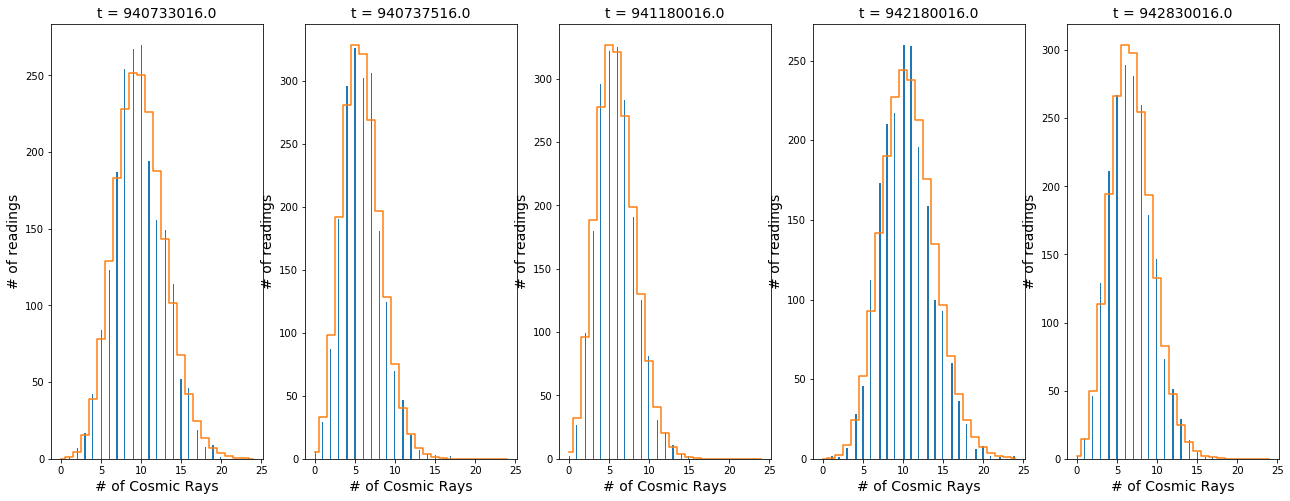

In [86]:
def backgroundPDF(atTime):
    x = np.linspace(0,24,25)
    f = stats.poisson.pmf(x,modelPCAvg(atTime))
    return x,f

fig,ax = plt.subplots(1,5)
plotIndex = [530000,575000,5000000,15000000,21500000]
for i in range(0,5):
    plt.subplot(1,5,i+1)
    pc = data[3,:(plotIndex[i]+2000)][plotIndex[i]:]
    plt.hist(pc,100)
    x,f = backgroundPDF(data[0,plotIndex[i]])
    plt.step(x,f*2000,where="mid")
    plt.title("t = " + str(data[0,plotIndex[i]]),fontsize=14)
    plt.xlabel("# of Cosmic Rays",fontsize=14)
    plt.ylabel("# of readings",fontsize=14)
plt.show()

Here I plotted my model pdf at 5 different times across the entire data set, the first 2 plots being **2a-b**, but the next 3 went further along the data set. As you can see, my model fits fairly well.<br>

Now I want to know, at the time of each of these plots, how many particles would you need to see to register as a 5 Sigma discovery? To answer this, I'll take the inverse of the integral of my model's Poisson distributions at each of these times, using the probability of 5 Sigma:

In [88]:
sigma5 = 1 - stats.norm.cdf(5,0,1)
for i in range(0,5):
    plot_t = data[0,plotIndex[i]]
    invPC = stats.poisson.ppf(1-sigma5,modelPCAvg(plot_t))
    print("5 Sigma discovery threshold at t = " + str(plot_t) + " s: " + str(invPC))

5 Sigma discovery threshold at t = 940733016.0 s: 29.0
5 Sigma discovery threshold at t = 940737516.0 s: 21.0
5 Sigma discovery threshold at t = 941180016.0 s: 22.0
5 Sigma discovery threshold at t = 942180016.0 s: 31.0
5 Sigma discovery threshold at t = 942830016.0 s: 23.0


# Problem 2

In this problem, there're 10 pictures of the same patch of night sky that's supposedly taken at different times. First I'll plot one of the images, where the brightness of the pixel is indicated by a color, as will be seen on a color bar:

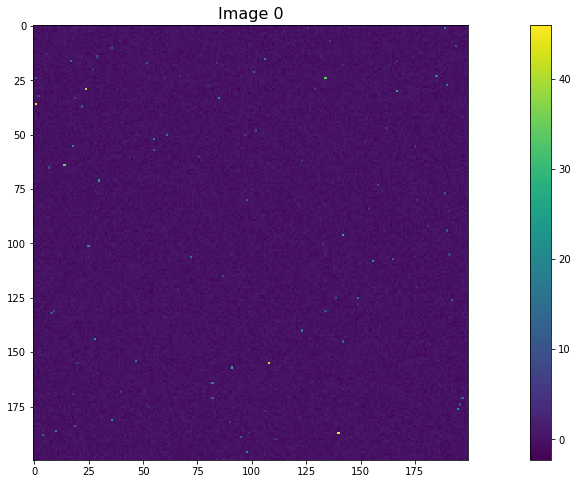

In [77]:
hf = h5py.File('images.h5', 'r')
img1,imgStack = np.array(hf.get('image1')),np.array(hf.get('imagestack'))
hf.close()

reStack = []
for i in range(0,10):
    reStack.append([])
    for j in range(0,200):
        reStack[i].append([])
        for k in range(0,200):
            reStack[i][j].append(imgStack[j][k][i])
imgStack = reStack

fig,ax = plt.subplots(1,1)
imgPlot = plt.imshow(imgStack[0])
plt.title("Image 0",fontsize=16)
plt.colorbar()
plt.show()

My goal for this problem is to search for a transient signal (like a supernova) among these 10 images. The problem though, is that the stars of the night sky act as signal contamination, since they're natural outliers to the standard background of space. To ignore the stars, I'm going to make a background pdf of the brightness of a single pixel in these images, then I'll make a list of every pixel that surpasses a certain sensitivity of my pdf. Most of these special pixels will be stars, but if an image contains an extra special pixel that no other image has, then I'll inspect that extra pixel as a transient signal. I'll start constructing this pdf by making a list of all of the brightness values among every image combined, and then plotting that list as a histogram:

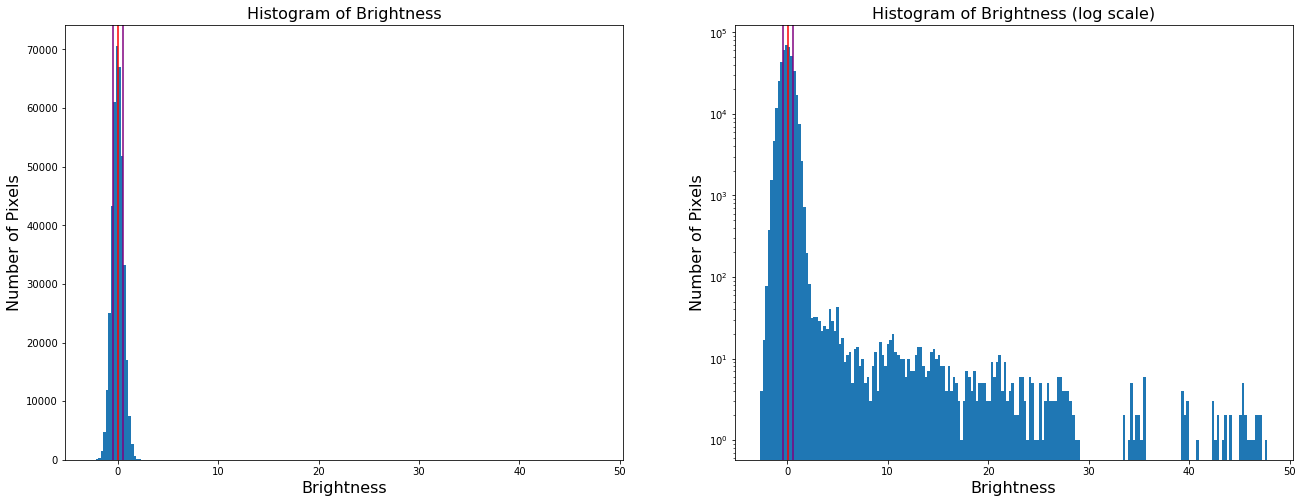

In [78]:
bList = []
for i in range(0,10):
    for j in range(0,200):
        for k in range(0,200):
            bList.append(imgStack[i][j][k])

def distProps(d):
    dAvg = sum(d)/len(d)
    dSquares = np.square(np.add(d,-dAvg))
    dSDev = math.sqrt(sum(dSquares)/(len(dSquares)-1))
    return dAvg,dSDev

avg,sDev = distProps(bList)

fig,ax = plt.subplots(1,2)
for i in range(0,2):
    plt.subplot(1,2,i+1)
    plt.hist(bList,200)
    plt.axvline(x=avg,color="Red")
    plt.axvline(x=(avg-sDev/2),color="Purple")
    plt.axvline(x=(avg+sDev/2),color="Purple")
    plt.xlabel("Brightness",fontsize=16)
    plt.ylabel("Number of Pixels",fontsize=16)
    if i == 0:
        plt.title("Histogram of Brightness",fontsize=16)
    elif i == 1:
        plt.title("Histogram of Brightness (log scale)",fontsize=16)
        plt.yscale("log")
plt.show()

At this point, I'd suggest that the background pdf is a Normal distribution because we can read negative brightness values (images are flat-fielded), the brightness distribution itself is continuous, and the majority of the distribution in log scale looks like a downwards parabola. I also plotted the average (red line) and the standard deviation (purple lines), which I'll be using to plot the background pdf:

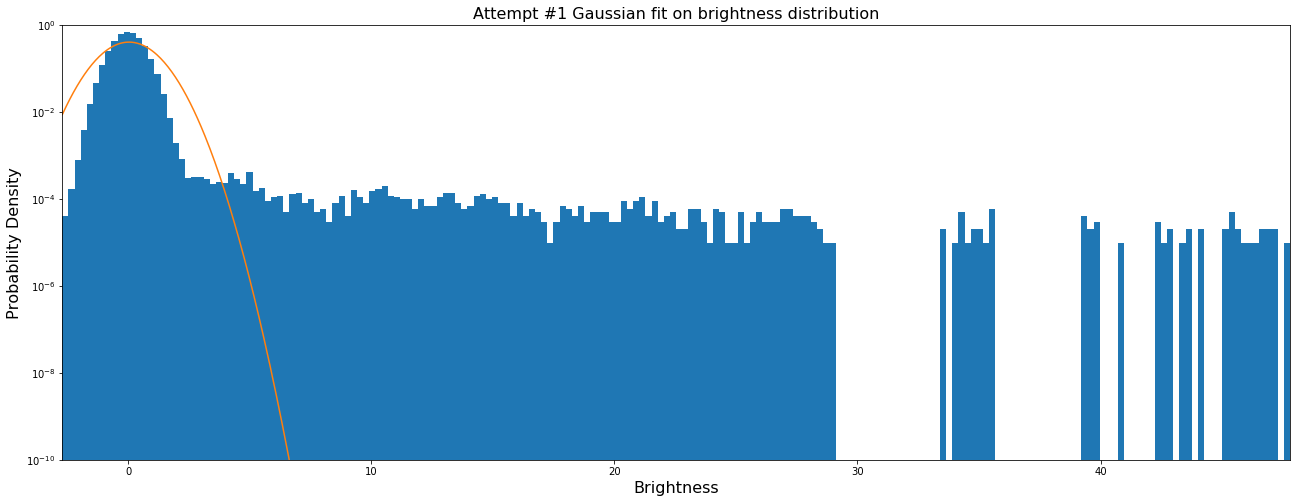

In [79]:
avg,sDev = distProps(bList)
x = np.linspace(min(bList),max(bList),1000)
f = stats.norm.pdf(x,avg,sDev)

fig,ax = plt.subplots(1,1)
count,bins,bars = plt.hist(bList,200,density=True)
plt.xlim(min(bList),max(bList))
plt.yscale("log")
plt.ylim(10**(-10),1)
plt.title("Attempt #1 Gaussian fit on brightness distribution",fontsize=16)
plt.xlabel("Brightness",fontsize=16)
plt.ylabel("Probability Density",fontsize=16)
plt.plot(x,f)
plt.show()

Even though I fit a Gaussian with the same mean and standard deviation as the overall brightness data, I ended up with a fit that was wider than the majority of the distribution. This I believe is the result of the signal contamination you can visibly see to the right of the parabola-like part of the distribution. Next I'll try to isolate the Gaussian part of this distribution to make my Gaussian fit:

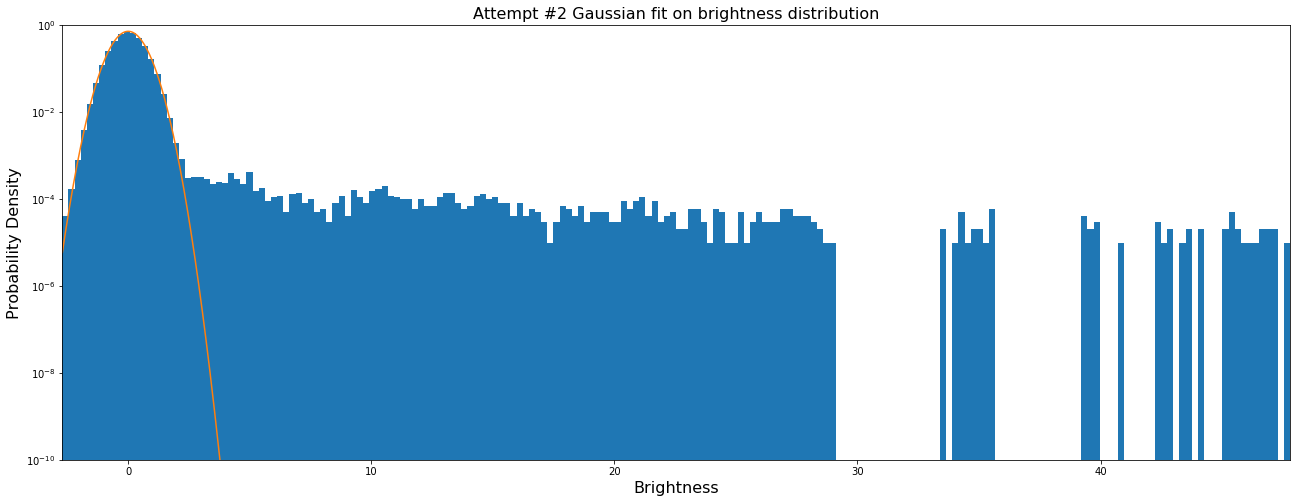

In [80]:
bTrim = []
for i in bList:
    if -2 <= i and i <= 2:
        bTrim.append(i)

avg,sDev = distProps(bTrim)

fig,ax = plt.subplots(1,1)
plt.hist(bList,200,density=True)
x = np.linspace(min(bList),max(bList),1000)
f = stats.norm.pdf(x,avg,sDev)
plt.plot(x,f)
plt.xlim(min(bList),max(bList))
plt.ylim([10**(-10),1])
plt.yscale("log")
plt.title("Attempt #2 Gaussian fit on brightness distribution",fontsize=16)
plt.xlabel("Brightness",fontsize=16)
plt.ylabel("Probability Density",fontsize=16)
plt.show()

Clearly, this fit works better, and I'll be using this fit to model the pdf of the brightness you would get looking at a pixel of empty space in one of the images. Before I use this as a model for my pdf though, I want to make sure that this model can be justified for all 10 images, since they're taken at different times. To determine this, I'll calculate the average and standard deviation of the brightness of each image in the same range that my model would work under:

In [82]:
for i in range(0,10):
    iList = []
    for j in range(0,200):
        for k in range(0,200):
            iB = imgStack[i][j][k]
            if -2 <= iB and iB <= 2:
                iList.append(imgStack[i][j][k])
    iAvg,iSDev = distProps(iList)
    print("Image " + str(i) + ": Mean = " + str(iAvg) + " Std.Dev. = " + str(iSDev))

Image 0: Mean = -0.002743220733847492 Std.Dev. = 0.5608716065548137
Image 1: Mean = -0.0027123490818379992 Std.Dev. = 0.5602413013767445
Image 2: Mean = 0.004730406279200476 Std.Dev. = 0.560326743163139
Image 3: Mean = 0.0009078762318920237 Std.Dev. = 0.561472567726903
Image 4: Mean = 0.0016400028619899013 Std.Dev. = 0.5600971507010363
Image 5: Mean = 0.004621185001895844 Std.Dev. = 0.558273214949386
Image 6: Mean = -0.004539702255568101 Std.Dev. = 0.5572623259118745
Image 7: Mean = -0.0012079230947745832 Std.Dev. = 0.560700218864951
Image 8: Mean = 0.0003687268794228579 Std.Dev. = 0.5605706299425168
Image 9: Mean = 0.002597987341282678 Std.Dev. = 0.5597496276220997


The slight changes in these means and standard deviations would hardly be noticable on the graphs, so I believe that my model pdf is consistent throughout time. However, my model pdf isn't consistent throughout space, as can be seen by the stars. Now I'll try to make a function that lists the pixels that exceed a certain sensitivity of discovery in my model pdf in each image:

In [89]:
pixS = [] # Special Pixels
avg,sDev = distProps(bTrim)
for i in range(0,10):
    pixS.append([])
    for j in range(0,200):
        for k in range(0,200):
            iB = imgStack[i][j][k]
            iProb = (1 - stats.norm.cdf(iB,avg,sDev))*40000
            iSig = stats.norm.ppf(1 - iProb,0,1)
            if iSig >= 100:
                pixS[i].append([j,k])
    print("Image " + str(i) + ": # of Special Pixels = " + str(len(pixS[i])))

Image 0: # of Special Pixels = 76
Image 1: # of Special Pixels = 78
Image 2: # of Special Pixels = 81
Image 3: # of Special Pixels = 80
Image 4: # of Special Pixels = 82
Image 5: # of Special Pixels = 78
Image 6: # of Special Pixels = 80
Image 7: # of Special Pixels = 75
Image 8: # of Special Pixels = 78
Image 9: # of Special Pixels = 79


Note that I used an absurdly high Sigma of 100 as my sensitivity, this however doesn't mean that the special pixels actually had a Sigma discovery this high, their Sigma was just an indefinitely high number in the code. I'll treat the list of special pixels pixS as a list of the locations of the brightest points in each image. Now, I'm going to mark which of these special pixels among the 10 images is truly unique, implying that they were a transient signal dependent on time:

5 unique, special pixels out of 90 special pixels


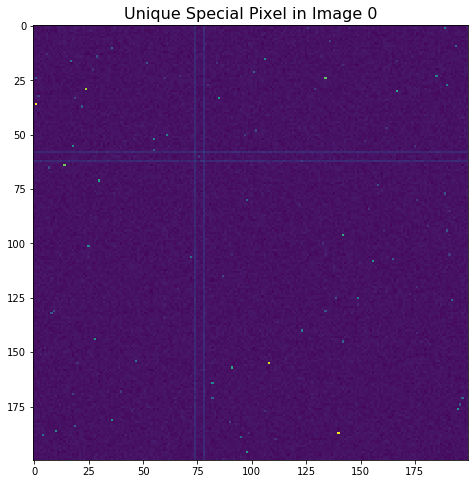

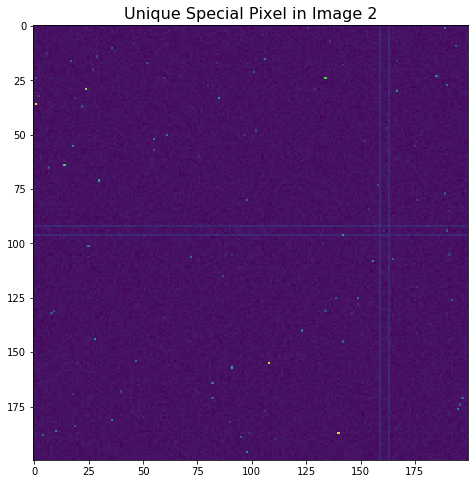

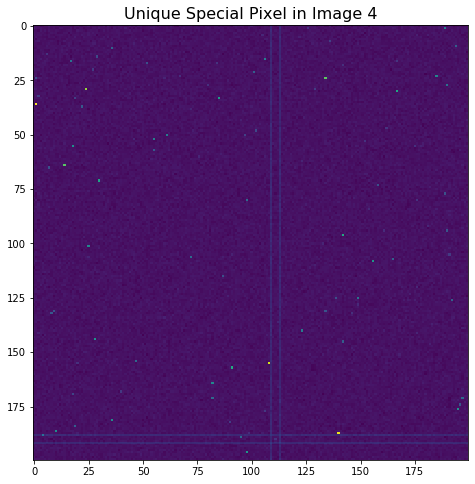

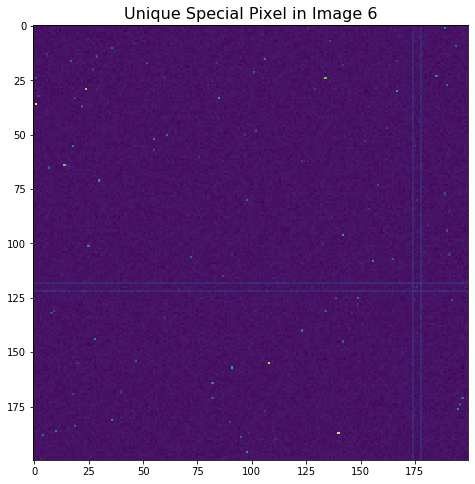

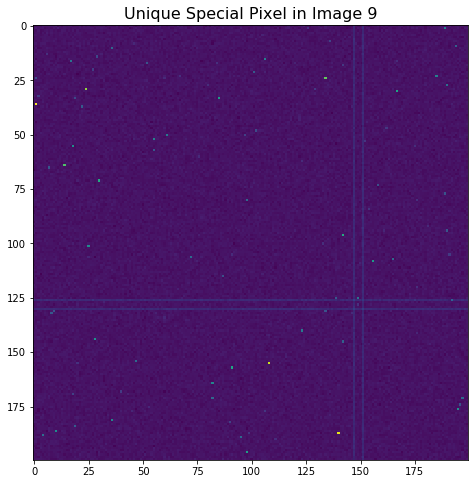

In [92]:
pixU = [[],[]] # Unique Pixels and their image origins
SPlist = [[],[],[]] # Special Pixel list and their image origins

for i in range(0,10): # Find common special pixels
    for j in range(0,len(pixS[i])):
        pLoc = pixS[i][j]
        if pLoc in SPlist[0]:
            pIndex = SPlist[0].index(pLoc)
            SPlist[1][pIndex].append(i)
        else:
            SPlist[0].append(pLoc)
            SPlist[1].append([i])

durSens = 1 # duration sensitivity
for i in range(0,len(SPlist[0])): # Find unique special pixels
    oDiff = np.diff(SPlist[1][i])
    continuous = True
    for j in oDiff:
        if j > 1:
            continuous = False
    if len(SPlist[1][i]) <= durSens and continuous == True:
        pixU[0].append(SPlist[0][i])
        pixU[1].append(SPlist[1][i])

print(str(len(pixU[0])) + " unique, special pixels out of " + str(len(SPlist[0])) + " special pixels")

for i in range(0,len(pixU[1])):
    fig,ax = plt.subplots(1,len(pixU[1][i]))
    for j in range(0,len(pixU[1][i])):
        plt.subplot(1,len(pixU[1][i]),j+1)
        imgPlot = plt.imshow(imgStack[pixU[1][i][j]])
        plt.title("Unique Special Pixel in Image " + str(pixU[1][i][j]),fontsize=16)
        plt.axhline(y=pixU[0][i][0]+2,alpha=0.3)
        plt.axhline(y=pixU[0][i][0]-2,alpha=0.3)
        plt.axvline(x=pixU[0][i][1]+2,alpha=0.3)
        plt.axvline(x=pixU[0][i][1]-2,alpha=0.3)
    plt.show()

Ultimately, by isolating all of the special pixels that were unique to each image, my model found 5 uniquely special pixels out of 90 that passed my sensitivity test. Unfortunately, I can visibly see these 5 signals in all of the images in nearly the same relative locations that they appear from. I would reason that what makes these 5 pixels unique is atmospheric or instrumental noise shifting the location of a stationary star by one pixel for each of those images.<br>

I'll note that I also played around with the brightness sensitivity and the duration sensitivity (if there was a signal over multiple, subsequent images), and found that even at 4 Sigma, my model couldn't find what I would consider a true transient signal.<br>

On one final note, my lab partner had a different objective than mine. Instead of looking for transient signals, he was looking for faint stars among the 10 images. The difference in how I would go about looking for faint stars is quite significant, since a faint star should be present over all 10 images, whereas a transient signal might only be present over 1 or 2 images. A faint star might not survive the brightness sensitivity test of the background pdf I developed due to its dim light, but you could strengthen its signal by averaging all of the images together into one average image, since its location should ideally not change throughout the images. The background pdf you would use for this average image would have to be a 10th order averaged convolution of a pdf like my own, which would result in a much thinner pdf than mine in the end, this average pdf would differentiate between the faint star and the true noise in the average image.